<a href="https://colab.research.google.com/github/pranjalmuchandi/ml-notebook-colab/blob/main/Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing the necessary libraries

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn beautifulsoup4

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline


# Loading the dataset and basic EDA

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


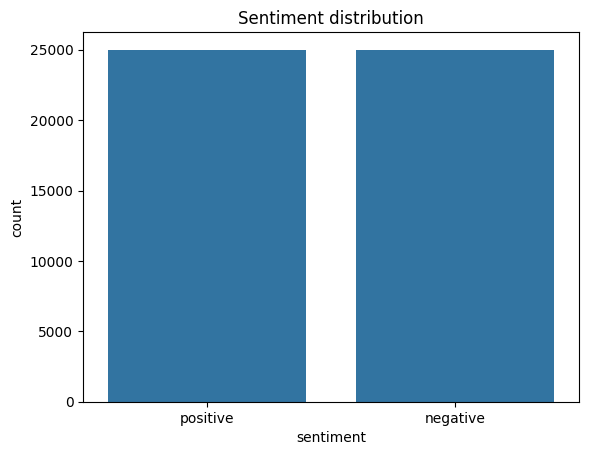

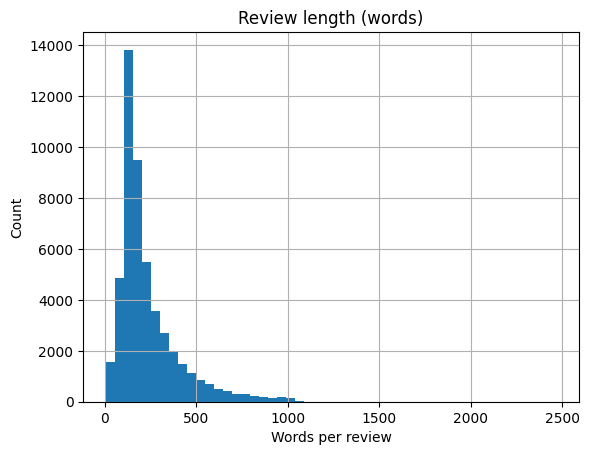

In [ ]:
df = pd.read_csv("IMDB Dataset.csv", engine='python')  # Kaggle IMDB 50K file [web:44]

print(df.head())
print(df["sentiment"].value_counts())
print(df.info())

# Class balance plot
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment distribution")
plt.show()

# Simple review length feature for EDA
df["review_len"] = df["review"].apply(lambda x: len(x.split()))
df["review_len"].hist(bins=50)
plt.title("Review length (words)")
plt.xlabel("Words per review")
plt.ylabel("Count")
plt.show()

# Text Cleaning Function

In [ ]:
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove non-alphabetic characters (keep basic punctuation if you want)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_clean"] = df["review"].apply(clean_text)


# Encode labels and samples

In [ ]:
# Encode sentiment: positive -> 1, negative -> 0
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})



# Train-Test-Split

In [ ]:
X = df["review_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 40000
Test size: 10000


# TF‑IDF + Logistic Regression pipeline

In [ ]:
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),   # unigrams + bigrams
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])


# Hyperparameter tuning

In [ ]:
param_grid = {
    "clf__C": [0.1, 1.0, 10.0],            # regularisation strength
    "clf__penalty": ["l2"],
    # "tfidf__max_features": [10000, 20000],   # uncomment if you want
}

grid = GridSearchCV(
    tfidf_lr,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Best CV F1: 0.9011188039162943


# Evaluation

Test accuracy: 0.9085

Classification report:

              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



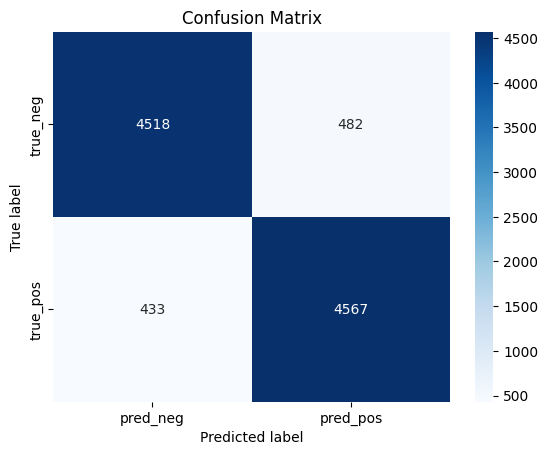

In [ ]:
y_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred_neg", "pred_pos"],
            yticklabels=["true_neg", "true_pos"])
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


# Simple function to predict new reviews

In [ ]:
def predict_sentiment(review_text):
    review_clean = clean_text(review_text)
    pred_label = best_model.predict([review_clean])[0]
    return "positive" if pred_label == 1 else "negative"

# Example:
print(predict_sentiment("This movie was absolutely fantastic!"))
print(predict_sentiment("Very exciting storyline."))


positive
positive
